In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('../flight_data.csv')
df = df[['DEPARTING_AIRPORT', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND', 'DEP_DEL15']]
df = df.dropna()
df = df[(df['PRCP'] > 0) | (df['SNOW'] > 0) | (df['SNWD'] > 0)]

# Exploratory Data Analysis

In [3]:
# Summary statistics
print(df.describe())

               PRCP          SNOW          SNWD          TMAX          AWND  \
count  2.040284e+06  2.040284e+06  2.040284e+06  2.040284e+06  2.040284e+06   
mean   3.298348e-01  1.004809e-01  2.910892e-01  6.603272e+01  9.220871e+00   
std    5.477771e-01  5.592078e-01  1.275971e+00  1.940030e+01  3.750086e+00   
min    0.000000e+00  0.000000e+00  0.000000e+00 -1.000000e+01  0.000000e+00   
25%    3.000000e-02  0.000000e+00  0.000000e+00  5.200000e+01  6.490000e+00   
50%    1.300000e-01  0.000000e+00  0.000000e+00  6.800000e+01  8.720000e+00   
75%    4.100000e-01  0.000000e+00  0.000000e+00  8.200000e+01  1.141000e+01   
max    1.163000e+01  1.720000e+01  2.520000e+01  1.140000e+02  3.378000e+01   

          DEP_DEL15  
count  2.040284e+06  
mean   2.407037e-01  
std    4.275109e-01  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    0.000000e+00  
max    1.000000e+00  


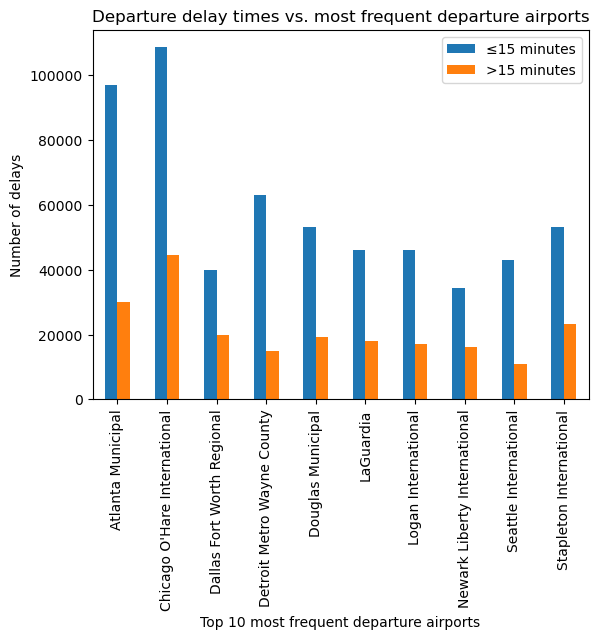

In [4]:
# Top 10 airports
top_airports = df['DEPARTING_AIRPORT'].value_counts().index[:10]
df_filtered = df[df['DEPARTING_AIRPORT'].isin(top_airports)]

# Bar chart
grouped = df_filtered.groupby(['DEPARTING_AIRPORT', 'DEP_DEL15']).size().unstack(fill_value=0)
grouped.plot(kind='bar', stacked=False)
plt.title('Departure delay times vs. most frequent departure airports')
plt.xlabel('Top 10 most frequent departure airports')
plt.ylabel('Number of delays')
plt.legend(['≤15 minutes', '>15 minutes']) 
plt.show()

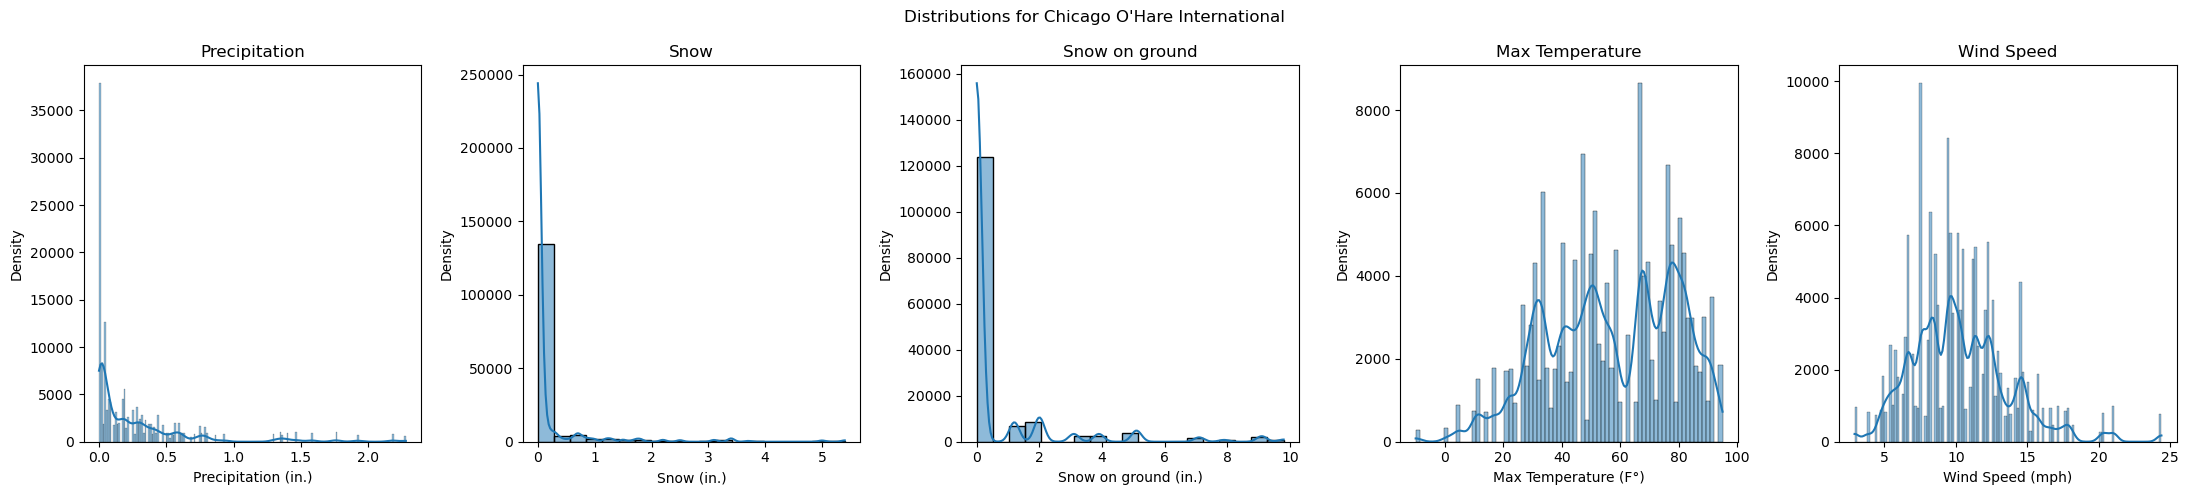

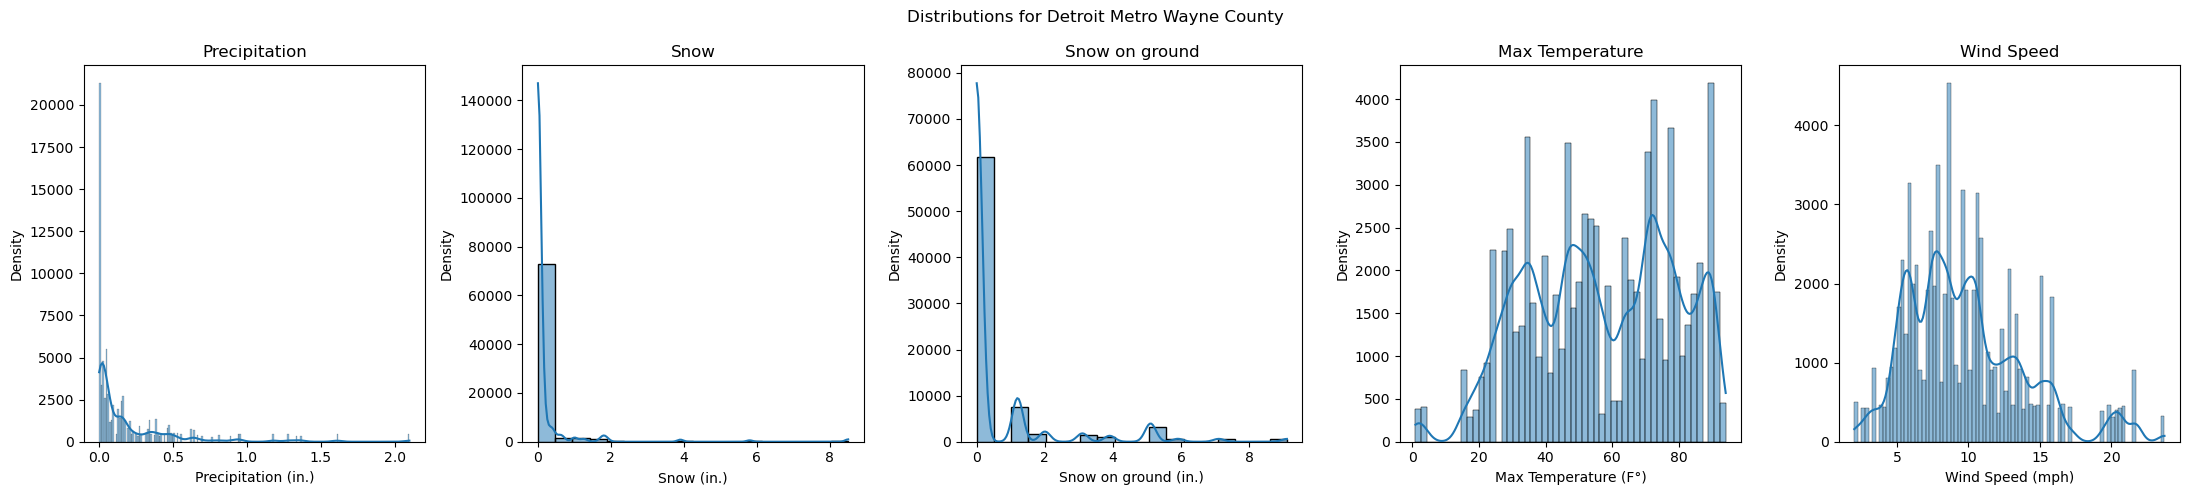

In [5]:
top_airports = ['Chicago O\'Hare International', 'Detroit Metro Wayne County']
df_filtered = df[df['DEPARTING_AIRPORT'].isin(top_airports)]

# Distributions
variables = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND']
titles = ['Precipitation', 'Snow', 'Snow on ground', 'Max Temperature', 'Wind Speed']
x_labels = ['Precipitation (in.)', 'Snow (in.)', 'Snow on ground (in.)', 'Max Temperature (F°)', 'Wind Speed (mph)']
for airport in top_airports:
    fig, axs = plt.subplots(1, len(variables), figsize=(22, 5))
    fig.suptitle(f'Distributions for {airport}')
    for i, var in enumerate(variables):
        sns.histplot(df_filtered[df_filtered['DEPARTING_AIRPORT'] == airport][var], kde=True, ax=axs[i])
        axs[i].set_title(titles[i])
        axs[i].set_xlabel(x_labels[i])
        axs[i].set_ylabel('Density')
    plt.tight_layout()
    plt.show()

## Normalize Features

In [6]:
scaler = StandardScaler()
df[['PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND', 'DEP_DEL15']] = scaler.fit_transform(
    df[['PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND', 'DEP_DEL15']])

## Dimensionality Reduction

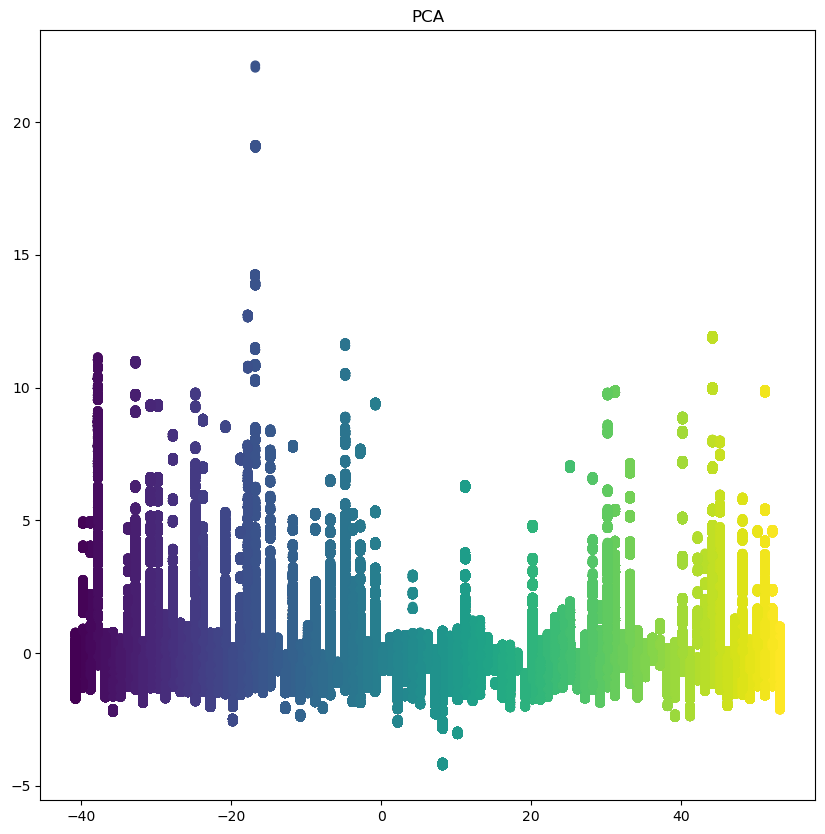

In [7]:
# Encode 'DEPARTING_AIRPORT' feature
le = LabelEncoder()
df['DEPARTING_AIRPORT'] = le.fit_transform(df['DEPARTING_AIRPORT'])

# Dimensionality reduction with PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(df)

# Plot
fig, axs = plt.subplots(1, figsize=(10, 10))
axs.scatter(pca_results[:, 0], pca_results[:, 1],
            c=df['DEPARTING_AIRPORT'])
axs.set_title('PCA')
plt.show()